In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
import statsmodels.api as sm
from sklearn import linear_model
from tqdm import tnrange, tqdm_notebook
from sklearn.metrics import mean_squared_error
from statsmodels.regression.quantile_regression import QuantReg

from sklearn.preprocessing import StandardScaler

import os

from sklearn.model_selection import train_test_split

In [16]:
# df=pd.read_csv('./ml-1m/movies.dat',sep='::')

c:\users\epsilon\dev\anaconda\envs\fortf\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [22]:
rt = np.loadtxt('./ml-1m/ratings.dat',delimiter='::',dtype=np.int64)

#### - UserIDs  1 ~ 6040 
#### - MovieIDs 1 ~ 3952
#### - Ratings  5-star scale (whole-star ratings only)
#### - Timestamp is represented in seconds since the epoch as returned by time(2)

- rating mean

In [18]:
# rt[:,2].mean()

- How many users participated

In [19]:
# len(rt)

In [23]:
users = len(np.unique(rt[:,0]))
users

6040

#### - mean of rating for each user

##### using for 

In [24]:
# user_mean =[]
# for x in range(users):
#     rt_ = rt[:,0] == (x+1)
#     if x ==0:
#         print(rt_)
#     user = rt[rt_,2]
#     user_mean.append(user.mean())

[ True  True  True ... False False False]


In [25]:
# user_mean

[4.188679245283019,
 3.7131782945736433,
 3.9019607843137254,
 4.190476190476191,
 3.1464646464646466,
 3.9014084507042255,
 4.32258064516129,
 3.884892086330935,
 3.7358490566037736,
 4.114713216957606,
 3.2773722627737225,
 3.8260869565217392,
 3.388888888888889,
 3.32,
 3.3233830845771144,
 3.0285714285714285,
 4.075829383886256,
 3.6491803278688524,
 3.5725490196078433,
 4.083333333333333,
 2.909090909090909,
 3.0673400673400675,
 3.3157894736842106,
 3.948529411764706,
 3.7411764705882353,
 2.96,
 4.171428571428572,
 3.7570093457943927,
 3.5833333333333335,
 3.488372093023256,
 3.73109243697479,
 3.625,
 3.498721227621483,
 3.8658536585365852,
 3.54040404040404,
 4.199430199430199,
 3.69811320754717,
 3.58,
 3.564516129032258,
 3.4479166666666665,
 3.48,
 3.74025974025974,
 4.125,
 3.6321243523316062,
 2.946127946127946,
 4.219512195121951,
 3.909090909090909,
 3.068561872909699,
 3.712962962962963,
 3.0697674418604652,
 3.825,
 3.5569620253164556,
 4.2368421052631575,
 4.025,
 4.

In [ ]:
# np.mean(user_mean)

- transform to Pandas 

In [28]:
rtp = pd.DataFrame(rt,columns=['usr_id','mv_id','star','timestamp'])

In [29]:
rtp['star_mean'] = rtp.groupby(['usr_id'])['star'].transform('mean')
rtp['star_std'] = rtp.groupby(['usr_id'])['star'].transform('std')

In [30]:
for qt in [0.0,0.25,0.5,0.75,1] :
    rtp['star_qt%d'%qt] = rtp.groupby(['usr_id'])['star'].transform(lambda x: x.quantile(q=qt))

#### integrate Data (movies.dat,ratings.dat,users.dat)
- "ratings.dat" UserID::MovieID::Rating::Timestamp
- "users.dat"   UserID::Gender::Age::Occupation::Zip-code
- "movies.dat"  MovieID::Title::Genres
> integrated data :  
UserID::UserID::Gender::Age::Occupation::Zip-code::
MovieID::MovieID::Title::Genres
::Rating
::Timestamp 

In [31]:
mv  = pd.read_csv('ml-1m/movies.dat',sep='::',names=['mov_id','title','genres'])
usr = pd.read_csv('ml-1m/users.dat' ,sep='::',names=['usr_id','gender','age','occupation','zip-code'])

c:\users\epsilon\dev\anaconda\envs\fortf\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
c:\users\epsilon\dev\anaconda\envs\fortf\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [32]:
usr = usr.set_index('usr_id')

In [33]:
mv  = mv.set_index('mov_id')

In [39]:
mv

,title,genres
mov_id,,
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy
...,...,...
3948,Meet the Parents (2000),Comedy
3949,Requiem for a Dream (2000),Drama
3950,Tigerland (2000),Drama


In [34]:
usr_info = rtp['usr_id'].transform([
                        lambda x : usr.loc[x]['gender'] ,
                        lambda x : usr.loc[x]['age'] ,
                        lambda x : usr.loc[x]['occupation'] ,
                        lambda x : usr.loc[x]['zip-code']                        
                       ])
usr_info.columns = ['gender','age','occupation','zip-code']

In [42]:
mv_info = rtp['mv_id'].transform([
                        lambda x : mv.loc[x]['title'] ,
                        lambda x : mv.loc[x]['genres']                
                       ])
usr_info.columns = ['gender','age','occupation','zip-code']
mv_info .columns = ['Title','Genres']

In [56]:
df = pd.concat([rtp,usr_info,mv_info],axis=1)

In [64]:
df

,usr_id,mv_id,star,timestamp,star_mean,star_std,star_qt0,star_qt1,gender,age,occupation,zip-code,Title,Genres
0,1,1193,5,978300760,4.188679,0.680967,5.0,5,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,4.188679,0.680967,5.0,5,F,1,10,48067,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,4.188679,0.680967,5.0,5,F,1,10,48067,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,4.188679,0.680967,5.0,5,F,1,10,48067,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,4.188679,0.680967,5.0,5,F,1,10,48067,"Bug's Life, A (1998)",Animation|Children's|Comedy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,3.577713,1.179719,4.0,5,M,25,6,11106,Weekend at Bernie's (1989),Comedy
1000205,6040,1094,5,956704887,3.577713,1.179719,4.0,5,M,25,6,11106,"Crying Game, The (1992)",Drama|Romance|War
1000206,6040,562,5,956704746,3.577713,1.179719,4.0,5,M,25,6,11106,Welcome to the Dollhouse (1995),Comedy|Drama
1000207,6040,1096,4,956715648,3.577713,1.179719,4.0,5,M,25,6,11106,Sophie's Choice (1982),Drama


#### store integrated data

In [67]:
df.to_csv('./ml-1m/integrated.csv')

In [68]:
import pickle

In [69]:
with open('integrated.pkl','wb') as f:
    pickle.dump(df,f)

<AxesSubplot:>

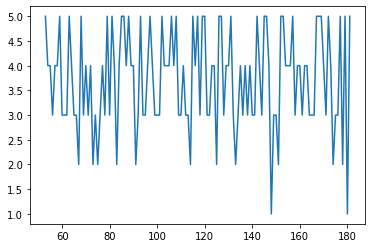

In [71]:
df.groupby(['usr_id']).get_group(2)['star'].plot()